In [1]:
# based on
# https://github.com/PierricJoulot/Astronomy/blob/7d0bc016bf3aac6984540381b47306ac8368ada7/Tutorials/transit/Transit_Fitting_with_BATMAN.ipynb

import numpy as np
import batman #package by Laura Kreidberg:  http://astro.uchicago.edu/~kreidberg/batman/
import emcee  #package by Dan Foreman-Mackey:  http://dan.iel.fm/emcee/current/
import corner #package by Dan Foreman-Mackey:  http://corner.readthedocs.io/en/latest/
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import os,sys

# For our simulated transits, Let's try to use these values as free parameters
# P, T0, RP/RS and b

## impact parameter is tricky since it depends on SMA, i, e and w
## assuming i=90, e=0, w=90 then b=0 regardless of SMA:
</br>

$\Large b = \frac{acosi}{R_S}\bigg( \frac{1-e^2}{1+esinw} \bigg)$

## what really needs to vary is inclination and therefore impact parameter since SMA can be assumed from light curve and TIC params.

</br>

# So are fit params for this approach will be P, T0, RP/RS and i

# Here are some helpful functions to condense our code

In [2]:
def phasefold(T0,time,period,flux):
    phase=(time- T0 + 0.5*period) % period - 0.5*period
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]

def SMA_AU_from_Period_to_stellar(Period,R_star,M_star):
    #assumes circular orbit
    #using Kepler's third law, calculate SMA
    #solar units
    RS = 6.955*10.0**10.0 #cm, solar radius
    MS = 1.989*10.0**33.0 #g, solar mass

    G = 6.6743*10.0**(-8.0) #cm^3 per g per s^2

    R = R_star*RS
    M = M_star*MS
    P=Period*60.0*24.0*60.0 #in seconds

    #SMA
    SMA_cm = ((G*M*(P**2))/(4*(np.pi**2)))**(1/3)   

    #note R_star is already in solar units so we need to convert to cm using
    # solar radius as a constant
    Stellar_Radius = R #now in cm

    SMA = SMA_cm / Stellar_Radius #now unitless (cm / cm)
    return SMA, SMA_cm

def convert_rp_in_re_to_rs(RP,R_star):
    R_sun=6.955*10**10 # cm
    R_earth=6.378*10**8 #cm
    
    rp_in_rs_units  = (RP/R_star)*(R_earth/R_sun) #in Stellar units
    
    return rp_in_rs_units

def convert_rp_in_rs_to_re(rp_in_rs_units,R_star):
    R_sun=6.955*10**10 # cm
    R_earth=6.378*10**8 #cm
    
    rp_in_re_units = (rp_in_rs_units*R_star)*(R_sun/R_earth) #in Earth units
    
    return rp_in_re_units

In [3]:




def BATMAN_MODEL(RP,T0,P,B,qld, t,y,yerr):
    import math
    
    R_sun=6.955*10**10 # cm
    R_earth=6.378*10**8 #cm

    rp = convert_rp_in_re_to_rs(RP,R_star)
    
    cad = np.nanmedian(np.diff(t))
    
    SMA , _ = SMA_AU_from_Period_to_stellar(P,R_star,M_star)
    
    I = math.degrees(np.arccos( (B*R_star) /SMA )) #assuming e=0, w=90
        
    #Initialize Parameters 
    params = batman.TransitParams()      # object to store transit parameters
    params.t0 = T0                       # time of inferior conjunction
    params.per = P                       # orbital period
    params.rp = rp                       # planet radius (in units of stellar radii)
    params.a = SMA                       # semi-major axis (in units of stellar radii)
    params.inc = I                       # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.limb_dark = "quadratic"       # limb darkening model ->"uniform", "linear", "quadratic", "nonlinear", etc.
    params.u = [qld[0],qld[1]]           # limb darkening coefficients

    mt = np.linspace(np.min(t), np.max(t), len(t))       # times at which to calculate light curve
    m = batman.TransitModel(params, mt, exp_time=cad)    # initializes model

    flux = m.light_curve(params)
    flux-= np.nanmedian(y)+1
    
    return mt, flux




In [4]:
def lnprob(parameters, plot=False):
        
    # pull out some model parameters
#     RP,T0,P,i = parameters
#     RP,T0,P,B = parameters
    P,T0,RP,B = parameters
    
    SMA , _ = SMA_AU_from_Period_to_stellar(P,R_star,M_star)
    
#     model_time,model_flux = BATMAN_MODEL(RP,T0,P,i,qld,t,y,yerr)
    model_time,model_flux = BATMAN_MODEL(RP,T0,P,B,qld,t,y,yerr)
    
    pf,ff = phasefold(T0,t,P,y)
    pfm,ffm = phasefold(T0,model_time,P,model_flux)
    if plot==True:
        
        plt.errorbar(24*pf,ff,yerr=yerr,fmt='o',alpha = 0.5,label='Simulated Data')
        plt.plot(24*pfm,ffm,label='MCMC Model',color='k',zorder=100)
        plt.xlabel('Time from Mid-Transit (days)')
        plt.ylabel('Flux')
        plt.xlim(-3*Dur,3*Dur)
        
        plt.legend(frameon=False)    
        plt.show()
        
        
    
    # let's put some hard limits on parameter space in place of more complicated priors
    
    #prior widths
    r0_width=0.1 # Earth Radii
    t0_width=1.0/24.0 # 1 hour in days
    p0_width=1.0/24.0 # 1 hour in days
    # a0_width=0.1 # stellar units
    # i0_width=3.0 # degrees
    b0_width=0.5 #impact parameter = unitless? degrees? radians?
    
    
    #Let's enforce some sensical limits to what parameter space gets explored
    
    if (B<0<SMA/R_star) & (B-b0_width < B < B+b0_width) & \
    (P-p0_width < P < P+p0_width) & (RP-r0_width < RP < RP+r0_width) & \
    (-3.5*Dur < np.nanmedian(pfm) < 3.5*Dur):        
        
        chisq = np.sum((y - model_flux)**2/(yerr)**2)
        lnp = np.sum(1/np.sqrt(2*np.pi*(yerr))) - 0.5*chisq #this is a gaussian likelihood
    
        return lnp
    else:
    
        return -np.inf

In [5]:
def main(p0,nwalkers,nsteps,ndim,lnprob):
    
    import time as clock

    start=clock.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    print("Running burn-in...")
    percent=0.1
    burnin = int(percent*nsteps)
    
    result = sampler.run_mcmc(p0, nsteps)
    sampler.reset() #don't include burnin values

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps)
    
    
    runtime=clock.time()-start

    if runtime>60:
        print('runtime ',runtime/60,' minutes')
    if runtime<60:
        print('runtime ',runtime,' seconds')
    return sampler, pos, prob, state

In [6]:
def sample_walkers(nsamples,sampler):
    percent=0.1
    burnin = int(percent*nsteps)
    
    models = []
    p, t0, rp, b = sampler.chain.T
    p_trimmed, t0_trimmed, rp_trimmed, b_trimmed = sampler.chain.T[:, burnin:nsteps, :]

    rp_samples = rp_trimmed.flatten()
    t0_samples = t0_trimmed.flatten()
    p_samples = p_trimmed.flatten()
    # a_samples = a_trimmed.flatten()
    # i_samples = i_trimmed.flatten()
    b_samples = b_trimmed.flatten()
    
    for j in range(0,nsamples,1):
        ind = np.random.randint(low=0,high=(nsteps-burnin)*nwalkers)
        sampled_time,sampled_model = BATMAN_MODEL(RP = rp_samples[ind], T0 = t0_samples[ind], P=p_samples[ind], B=b_samples[ind],\
                                                  qld=qld,t=t,y=y,yerr=yerr)
    
        models.append(sampled_model)

    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread, p_samples, t0_samples, rp_samples, b_samples

In [7]:
def get_quantile_values(x):
    from corner import quantile
    q=np.array([0.16,0.5,0.84]) #array of quantiles (maybe just 0.16,0.84)?
    q_16, q_50, q_84 = quantile(x, [0.16, 0.5, 0.84], weights=None)
    q_m, q_p = q_50 - q_16, q_84 - q_50
#     print(q_m,q_50,q_p)
    return q_m,q_50,q_p

In [8]:
def MCMC_transit_fit(input_LC, input_TLS_params, nwalkers, niters,use_TLS_model):
    import time as clock
    import emcee
    import corner
    start=clock.time()
    
    # light curve
    t = np.array(input_LC['Time'].to_list())
    y = np.array(input_LC['Flux'].to_list())
    yerr = np.array(input_LC['Flux Error'].to_list())
    
    # TLS best fit parameters
    P = input_TLS_params['Period'].item()
    Perr= input_TLS_params['Period Error'].item()
    T0= input_TLS_params['T0'].item()
    Dur=input_TLS_params['Duration'].item()
    RP=input_TLS_params['Planet Radius'].item()
    RP_RS=input_TLS_params['RP_RS'].item()
    RP_RSerr=input_TLS_params['RP_RSerr'].item()
    
    #stellar params
    qld_a=input_TLS_params['qld_a'].item()
    qld_b=input_TLS_params['qld_b'].item()
    u=[qld_a,qld_b]
    R_star=input_TLS_params['R_star'].item()
    M_star=input_TLS_params['M_star'].item()    
    
    if use_TLS_model=='yes':
        # TLS Model
        TLS_model_time = np.array(input_TLS_model['Time'].to_list())
        TLS_model = np.array(input_TLS_model['Model'].to_list())
    
    #make sure y is zero centered
    y = y - np.nanmedian(y)
    
    times=t
    data=y
    
    #assumption about impact parameter starting point
    B=0 #assuming i = 90, since cos(90 deg ) = 0
    
    params = [RP, T0, P, B]    
    print('initializing MCMC model')    
    model_time,model_flux = BATMAN_MODEL(RP,T0,P,B,qld,t,y,yerr)
    
    fig=plt.figure(figsize=(12,6))
    
    if use_TLS_model=='yes':
        ax1=fig.add_subplot(311)
        ax2=fig.add_subplot(312)
        ax3=fig.add_subplot(313)
    if use_TLS_model=='no':
        ax1=fig.add_subplot(211)
        ax2=fig.add_subplot(212)
        ax2=fig.add_subplot(212)        
    



    ax1.plot(t, y, "k.", ms=4, label="data",rasterized=True)
    if use_TLS_model=='yes':        
        ax1.plot(TLS_model_time,TLS_model, 'r.',lw=1, label="planet b TLS model",rasterized=True)
    ax1.plot(model_time,model_flux,'g.', lw=1, label="planet b model",rasterized=True)


    ax1.set_xlim(t.min(), t.max())
    ax1.set_ylabel("relative flux")
    ax1.set_xlabel("time [days]")
    ax1.legend(loc='best',fontsize=10,ncol=3,handletextpad=0.1)
    ax1.set_title("Initialized model as starting point for MCMC")


    pfm,ffm = phasefold(T0,model_time,P,model_flux)
    pf,ff = phasefold(T0,t,P,y)

    ax2.set_title('Initialized model')
    ax2.plot(24*pf,ff,'k.',markersize=3,label='data',zorder=-10,rasterized=True)
    ax2.plot(24*pfm,ffm,'g.-',label='planet b model',rasterized=True)

    ax2.set_xlim(-3.5*Dur,3.5*Dur)
    ax2.set_xlabel('Phase [hours since '+str(np.round(T0,3))+' BTJD]')
    ax2.set_ylabel("Relative Flux")
    ax2.legend(loc='best',fontsize=10,ncol=3,handletextpad=0.1)

    if use_TLS_model=='yes':    
        pfTLS,ffTLS = phasefold(T0,TLS_model_time,P,TLS_model)
        ax3.plot(24*pf,ff,'k.',markersize=3,label='data',zorder=-10,rasterized=True)
        ax3.plot(24*pfTLS,ffTLS,'r.-',label='planet b TLS model',rasterized=True)
        ax3.set_xlim(-3.5*Dur,3.5*Dur)
        ax3.set_xlabel('Phase [hours since '+str(np.round(T0,3))+' BTJD]')
        ax3.set_ylabel("Relative Flux")
        ax3.legend(loc='best',fontsize=10,ncol=3,handletextpad=0.1)
    
    
    fig.tight_layout(pad=1)
    fig.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_initial_guess.png',bbox_inches='tight')
    fig.show()
    print(' ')
    if (clock.time()-start)> 60:
        print('Initilization complete. Runtime ',(clock.time()-start)/60,' minutes')
    if (clock.time()-start)< 60:
        print('Initilization complete. Runtime ',(clock.time()-start),' seconds')
    print(' ')
    
    
    print('Sampling Posteriors')
    ndim, nwalkers, nsteps = 4, nwalkers, niters
    
    
    #prior widths
    r0_width=0.1 # Earth Radii
    t0_width=1.0/24.0 # 1 hour in days
    p0_width=1.0/24.0 # 1 hour in days
    # a0_width=0.1 # stellar units
    # i0_width=3.0 # degrees
    b0_width=0.5 #impact parameter = unitless? degrees? radians?

    rp_init = np.random.uniform(RP-r0_width, RP+r0_width, nwalkers)
    t0_init = np.random.uniform(T0-t0_width, T0+t0_width, nwalkers)
    p_init  = np.random.uniform(P-p0_width, P+p0_width, nwalkers)
    # a_init  = np.random.uniform(SMA-a0_width, SMA+a0_width, nwalkers)
    # i_init  = np.random.uniform(I-i0_width, I+i0_width, nwalkers)
    b_init  = np.random.uniform(B-b0_width, B+b0_width, nwalkers)

    #fixed t,y,yerr


    # guesses=[rp_init, t0_init, p_init,a_init]
    # guesses=[rp_init, t0_init, p_init,i_init]
#     guesses=[rp_init, t0_init, p_init,b_init]
    guesses=[p_init, t0_init, rp_init,b_init]

    p0 = np.transpose(guesses)
    
    sampler, pos, prob, state = main(p0,nwalkers,nsteps,ndim,lnprob)
    
       
    
    #plot posteriors and final MCMC model
    
    samples = sampler.flatchain
#     labels = ['RP','T0','P','b']
    labels = ['P','T0','RP','b']
    
    letters='b'
    labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
    labels += ["$T0_{{{0}}} $ [BTJD]".format(i) for i in letters]
    labels += ["$R_{P}$"]
    labels += ["impact param {0}".format(i) for i in letters]
    
    figure = corner.corner(samples,labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs=dict(fontsize=10));
    mean = 4*np.random.rand(ndim)
    value1=mean
    value2 = np.mean(samples, axis=0)
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value1[i], color="g")
        ax.axvline(value2[i], color="r")
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value2[xi], color="r")
            ax.axhline(value2[yi], color="r")
            ax.plot(value2[xi], value2[yi], "sr")

    figure.tight_layout()
    figure.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_MCMC_corner.png',bbox_inches='tight')
    figure.show()
    
    
    print(' ')
    print('Finished!')
    print('')
    
    #sample posteriors to get best fits and errors on models
    med_model,spread, p_samples, t0_samples, rp_samples, b_samples = sample_walkers(nsteps,sampler)    
    
    rpmin,rpmed,rpmax = get_quantile_values(rp_samples);print('')
    t0min,t0med,t0max = get_quantile_values(t0_samples);print('')
    pmin,pmed,pmax = get_quantile_values(p_samples);print('')
    bmin,bmed,bmax = get_quantile_values(b_samples)
    
    model_time,model_flux = BATMAN_MODEL(RP=rpmed,T0=t0med,P=pmed,B=bmed,qld=qld,t=t,y=y,yerr=yerr)

    pf,ff = phasefold(T0,t,P,y)
    pfm,ffm = phasefold(t0med,model_time,pmed,model_flux)


    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(111)
    ax1.plot(24*pf, ff, ".k", label="data", zorder=-1000)

    ax1.plot(24*pfm,ffm, color="C1", label="model")
    plt.xlabel('Time from Mid-Transit (days)')
    plt.ylabel('Flux')
    plt.xlim(-3*Dur,3*Dur)     
    
    art = plt.fill_between(24*pfm,ffm-spread,ffm+spread, color="C1", alpha=0.5, zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.5f} +/- {1:.5f} d".format(pmed, pmin)
    ax1.annotate(txt,(0, 0),xycoords="axes fraction",xytext=(5, 5),\
        textcoords="offset points", ha="left",va="bottom",fontsize=12)

    ax1.legend(fontsize=10, loc=4,ncol=3)
    ax1.set_xlabel("Phase [hours since "+str(np.round(t0med,4))+"]")
    ax1.set_ylabel("Relative Flux")
    ax1.set_xlim(-3*Dur,3*Dur)
    ax1.set_title('TIC '+str(ID)+' Sector '+str(Sector)+' best fit MCMC model')
    fig.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_bestfit_MCMC_model.png',bbox_inches='tight')
    fig.show()
    
    
    if (clock.time()-start)> 60:
        print('Total runtime ',(clock.time()-start)/60,' minutes')
    if (clock.time()-start)< 60:
        print('Total runtime ',(clock.time()-start),' seconds')
    print(' ')
        
        
    return sampler, pos, prob, state

In [9]:
def Transit_duration(Period, SMA_cm, R_star, R_planet_RE):
    RE = 6.378*10.0**8 #cm
    RS = 6.955 *10.0**10 #cm    
    A = Period/np.pi #in days
    B =(R_star*RS +R_planet_RE*RE)/ SMA_cm #in cm
    
    T_dur = A*np.arcsin(B) #in days
    return T_dur

In [10]:
# Let's simulated a TESS LC with transits

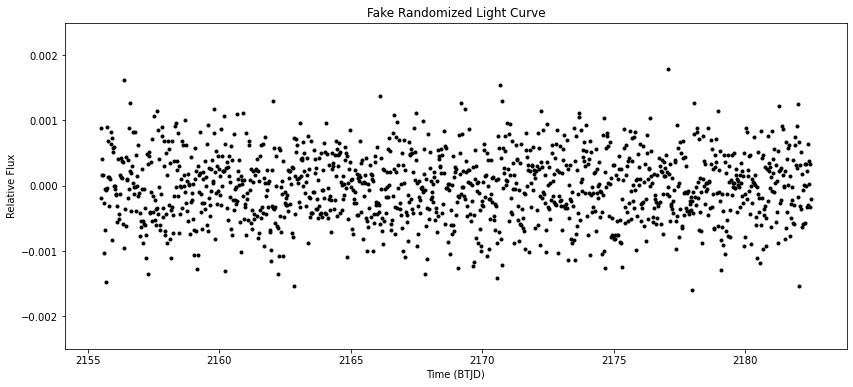

In [11]:
ID = 123456789
Sector=0
path = os.getcwd()+'/'



fs=10 #fontsize for text in figures

ndays = 27 #days
cadence= 30/(60*24) # 30 minute cadence in days ~ 0.021
pts_per_day = int(np.round(((1/cadence))+1,1)) 


scatter_frac = 500/1e6  # add 500 ppm scatter to data to make it somewhat realistic

start=0.0
stop=ndays
stepsize=ndays*pts_per_day

t = 2459155.5 + np.linspace(start, stop, stepsize) - 2457000  #in BTJD; 2459155.5 = 11/2/2020

#let's add random noise to our flux "measurements"
y = np.random.randn(t.size) * scatter_frac #+1 if you want it to be centered on 1.0
yerr = np.ones_like(y) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.gca().ticklabel_format(useOffset=False)
plt.plot(t ,y,marker='.',color='black',linestyle='none')
plt.xlabel("Time (BTJD)")
plt.ylabel("Relative Flux")
plt.title("Fake Randomized Light Curve")
plt.ylim(0.9975-1,1.0025-1)
plt.show()

In [12]:
# Let's say this is a Mdwarf star
M_star = 0.25 #in solar masses
R_star = 0.25 #in solar radii
qld = [0.3,0.3] #quadratic limb darkening parameters

R_sun=6.955*10**10 # cm
R_earth=6.378*10**8 #cm

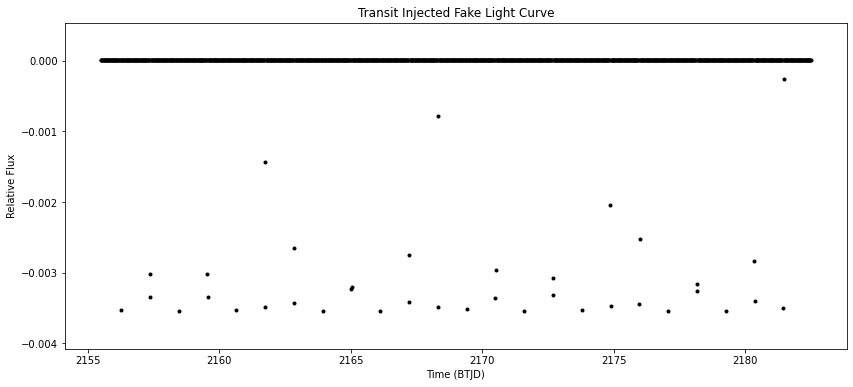

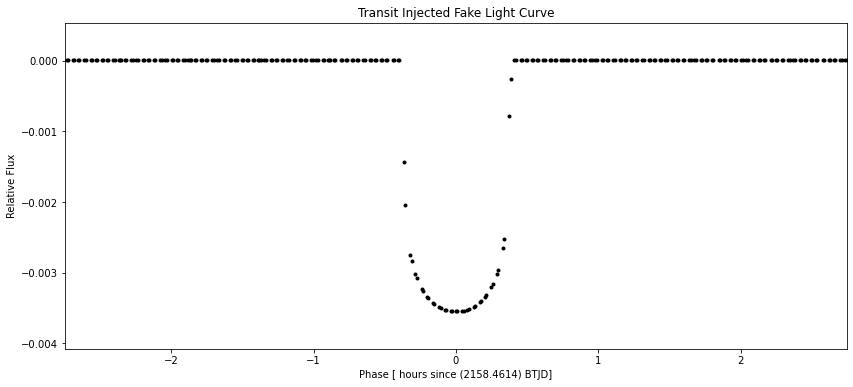

In [13]:
#prepare input parameters

#randomly sample a time from within 1st 5 days of data as transit time
import random
T0= float(random.sample(list(t[(2155<t) & (t<2160)]),1)[0]) #BTJD

#pick between 1 - 27/3 days to get min 3 transits
LC_duration = float(np.max(t) - np.min(t))
P = float(random.uniform(1, LC_duration/3)) #days

#let's say this error is pretty accurate down to 15 minutes
Perr=float(15/(60*24) )# days

#let's select our planet size
RP= float(1.5) #in Earth Radii
RPerr=float(0.25) #in Earth Radii

Depth= float((RP*R_earth/(R_star*R_sun))**2 )#unitless
RP_RS =float(np.sqrt(Depth)) #unitless
RP_RSerr = 0.1 #unitless

#from our random Period, let's calculate semi-major axis (SMA)
SMA,SMA_cm = SMA_AU_from_Period_to_stellar(P, R_star, M_star) #scaled SMA (unitless) and in cm

#let's calculate transit duration from P, RS, RP and SMA (assuming circular orbit)
Dur = 24*float(Transit_duration(P, SMA_cm, R_star,RP)) #in hours


# other assumptions for a circular transit
B=0
e=0
w=90


# With our transit parameters defined, let's simulate our transits with BATMAN

model_time,model_flux = BATMAN_MODEL(RP,T0,P,B,qld, t,y,yerr)



plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(model_time,model_flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (BTJD)")
plt.ylabel("Relative Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(np.min(model_flux)-np.nanstd(model_flux),np.max(model_flux)+np.nanstd(model_flux))
plt.show()


pfm,ffm = phasefold(T0,model_time,P,model_flux)

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(24*pfm,ffm,marker='.',color='black',linestyle='none')
plt.xlabel("Phase [ hours since ("+str(np.round(T0,4))+") BTJD]")
plt.ylabel("Relative Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(np.min(model_flux)-np.nanstd(model_flux),np.max(model_flux)+np.nanstd(model_flux))
plt.xlim(-3.5*Dur,3.5*Dur)
plt.show()

In [14]:
input_LC = pd.DataFrame({'Time':t,'Flux':y,'Flux Error':yerr})
input_Transit_params = pd.DataFrame({'Period':P,'Period Error':Perr,'T0':T0,'Duration':Dur,'Planet Radius':RP,'RP_RS':RP_RS,'RP_RSerr':RP_RSerr,'qld_a':qld[0],'qld_b':qld[1],'R_star':R_star,'M_star':M_star},index=[0])
cad = cadence

initializing MCMC model


<ipython-input-8-38c277af8d6e>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=fig.add_subplot(212)
<ipython-input-8-38c277af8d6e>:97: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Dax/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


 
Initilization complete. Runtime  0.7327861785888672  seconds
 
Sampling Posteriors
Running burn-in...


<ipython-input-3-ca4c380394cd>:13: RuntimeWarning: invalid value encountered in arccos
  I = math.degrees(np.arccos( (B*R_star) /SMA )) #assuming e=0, w=90


Running production...
runtime  1.091742249329885  minutes


<ipython-input-8-38c277af8d6e>:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


 
Finished!






<ipython-input-8-38c277af8d6e>:217: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Total runtime  1.1968205213546752  minutes
 


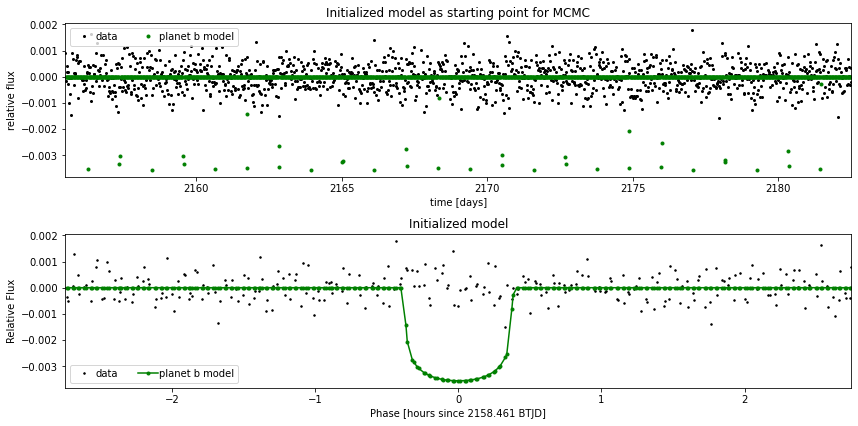

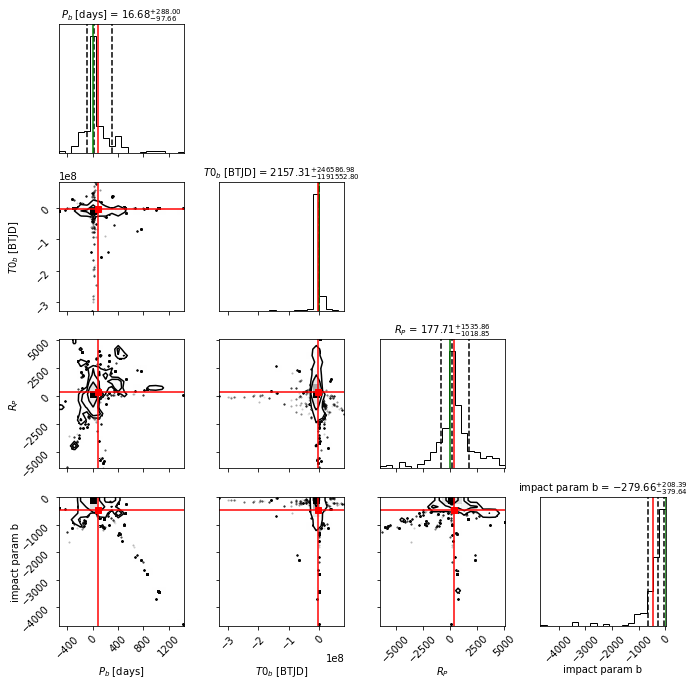

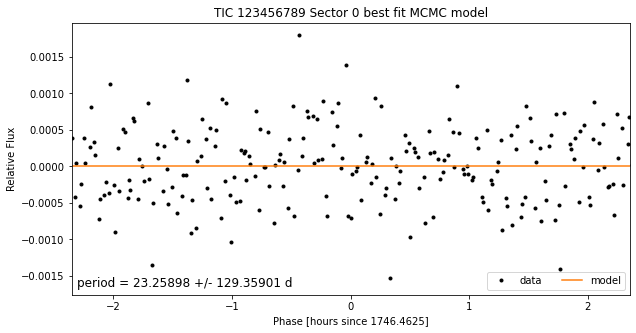

In [15]:
# MCMC parameters
nwalkers = 25
nsteps = 1000#0



sampler, pos, prob, state = MCMC_transit_fit(input_LC, input_Transit_params, nwalkers=nwalkers, niters=nsteps, use_TLS_model='no')

# It seems no matter what that the range of parameter space is being tested, the final posteriors are ridiculous. 

# Perhaps there's a way to merge the PyMC3 exoplanet distributions and models with the emcee ensemble sampler?


## Found this: https://dfm.io/posts/emcee-pymc3/